# Question 7

How accurately can we predict the length of a conversation with ChatGPT based on the initial prompt and context provided?

In [1]:
"""
Project: Predicting the Length of a Conversation with ChatGPT
Description: This script loads and cleans the data, performs feature extraction (including NLP features), 
             trains three models (Random Forest, Gradient Boosting with grid search, and a Neural Network), 
             evaluates them, and saves the resulting plots and metrics.
"""

# Import Libraries

import pandas as pd
import numpy as np
import re
import time
from collections import deque, Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing and Machine Learning
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

# NLP and Text Processing
import spacy
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from textblob import TextBlob

# Deep Learning (Neural Network)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## 1. Data Loading and Cleaning

In [2]:
def clean_and_merge_data(discussion_df, issue_df):
    """
    Merge discussion and issue datasets, process date columns, add a conversation length column,
    and remove duplicates.
    """
    # Add source prefix to distinguish conversation IDs
    discussion_df['conversation_id'] = 'discussion_' + discussion_df['conversation_id'].astype(str)
    issue_df['conversation_id'] = 'issue_' + issue_df['conversation_id'].astype(str)

    # Add source column
    discussion_df['source'] = 'discussion'
    issue_df['source'] = 'issue'

    # Select common columns and merge datasets
    common_columns = list(set(discussion_df.columns).intersection(set(issue_df.columns)))
    merged_df = pd.concat([discussion_df[common_columns], issue_df[common_columns]], ignore_index=True)

    # Convert date columns to datetime format
    date_columns = ['CreatedAt', 'UpdatedAt', 'ClosedAt']
    for col in date_columns:
        merged_df[col] = pd.to_datetime(merged_df[col], errors='coerce')

    # Calculate conversation length based on numPrompts
    merged_df['conversation_length'] = merged_df['numPrompts'].fillna(0).astype(int)

    # Remove duplicate rows to avoid redundancy
    merged_df.drop_duplicates(keep='first', inplace=True)

    # Fill missing text values with an empty string
    text_columns = ['Prompt', 'Answer', 'conversationTitle', 'issueDesc', 'issueTitle']
    merged_df[text_columns] = merged_df[text_columns].fillna('')

    print(f"Merged dataset shape: {merged_df.shape}")
    print(f"Null values:\n{merged_df.isnull().sum()}")
    
    return merged_df

# Load datasets from CSV files
discussion_df = pd.read_csv('../data/data_clean/discussiondata_cleaned.csv')
issue_df = pd.read_csv('../data/data_clean/issuedata_cleaned.csv')

# Clean and merge the data
merged_df = clean_and_merge_data(discussion_df, issue_df)

Merged dataset shape: (1562, 20)
Null values:
conversationTitle        0
UpdatedAt                0
Prompt                   0
source                   0
issueTitle               0
ListOfCode               0
mentionText              0
RepoLanguage           123
Answer                   0
ClosedAt               995
Detected_Language        1
CreatedAt                0
sourceURL                0
conversation_id          0
Number                   0
numPrompts               0
mentionProperty          0
RepoName                 0
issueDesc                0
conversation_length      0
dtype: int64


## 2. Code Extraction from Text

In [3]:
def extract_code(text):
    """
    Extract code snippets using regex. It first looks for triple backticks and then for indented lines.
    """
    if pd.isna(text) or not isinstance(text, str):
        return "No code found in input"

    # Look for code blocks enclosed in triple backticks
    match = re.findall(r"```(?:\w+)?\n?(.*?)\n?```", text, re.DOTALL)
    if match:
        return "\n".join(match).strip()

    # Look for indented code blocks (4+ spaces or tabs)
    match = re.findall(r"(?m)^(?:\s{4,}|\t+)(.*)", text)
    return "\n".join(match).strip() if match else "No code found in input"

# Apply code extraction to both 'Prompt' and 'Answer' columns
merged_df['extractedCode_Prompt'] = merged_df['Prompt'].apply(extract_code)
merged_df['extractedCode_Answer'] = merged_df['Answer'].apply(extract_code)

## 3. Feature Engineering

In [4]:
# Text Length Features
merged_df['prompt_length'] = merged_df['Prompt'].apply(lambda x: len(x.split()))
merged_df['answer_length'] = merged_df['Answer'].apply(lambda x: len(x.split()))
merged_df['prompt_char_length'] = merged_df['Prompt'].apply(len)
merged_df['answer_char_length'] = merged_df['Answer'].apply(len)

# Code Presence Features
merged_df['has_code_prompt'] = merged_df['extractedCode_Prompt'].apply(lambda x: 1 if x != "No code found in input" else 0)
merged_df['has_code_answer'] = merged_df['extractedCode_Answer'].apply(lambda x: 1 if x != "No code found in input" else 0)

# Sentiment Analysis using TextBlob
merged_df['prompt_sentiment'] = merged_df['Prompt'].apply(lambda x: TextBlob(x).sentiment.polarity)
merged_df['answer_sentiment'] = merged_df['Answer'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Fill missing RepoLanguage values before encoding
merged_df['RepoLanguage'].fillna("Unknown", inplace=True)

# Label Encoding for Categorical Variables
lang_encoder = LabelEncoder()
merged_df['RepoLanguage_encoded'] = lang_encoder.fit_transform(merged_df['RepoLanguage'].astype(str))
merged_df['Detected_Language_encoded'] = lang_encoder.fit_transform(merged_df['Detected_Language'].astype(str))

C:\Users\vidal\AppData\Local\Temp\ipykernel_30464\25955763.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['RepoLanguage'].fillna("Unknown", inplace=True)


## 4. NLP Feature Extraction

In [5]:
# Load the small English model from spaCy
nlp = spacy.load("en_core_web_sm")

def extract_nlp_features(text):
    """
    Extract linguistic features from text using spaCy:
    - Number of words, nouns, verbs, adjectives
    - Lexical diversity (unique word ratio)
    - Number of named entities
    """
    doc = nlp(text)
    num_words = len(doc)
    num_nouns = sum(1 for token in doc if token.pos_ == "NOUN")
    num_verbs = sum(1 for token in doc if token.pos_ == "VERB")
    num_adj = sum(1 for token in doc if token.pos_ == "ADJ")
    unique_words = set(token.text.lower() for token in doc if token.is_alpha)
    lexical_diversity = len(unique_words) / num_words if num_words > 0 else 0
    num_entities = len(doc.ents)
    return num_words, num_nouns, num_verbs, num_adj, lexical_diversity, num_entities

# Apply the NLP feature extraction function on the 'Prompt' column
nlp_features = merged_df['Prompt'].apply(extract_nlp_features)
merged_df[['num_words', 'num_nouns', 'num_verbs', 'num_adj', 'lexical_diversity', 'num_entities']] = pd.DataFrame(nlp_features.tolist(), index=merged_df.index)

# Additional Feature Engineering
merged_df['question_marks'] = merged_df['Prompt'].apply(lambda x: x.count('?'))
merged_df['readability_score'] = merged_df['Prompt'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
merged_df['sentence_length_variation'] = abs(merged_df['prompt_length'] - merged_df['answer_length'])
merged_df['code_presence_ratio'] = (merged_df['has_code_prompt'] + merged_df['has_code_answer']) / 2


## 5. Embeddings and Topic Modeling

In [6]:
# Word2Vec Embedding for Prompts
tokenized_prompts = merged_df['Prompt'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized_prompts, vector_size=100, window=5, min_count=2, workers=4)
merged_df['w2v_prompt_vector'] = merged_df['Prompt'].apply(
    lambda x: np.mean([w2v_model.wv[word] for word in x.split() if word in w2v_model.wv] or [np.zeros(100)], axis=0)
)

# Sentence Embedding using SentenceTransformer
sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
merged_df['sentence_embedding'] = merged_df['Prompt'].apply(lambda x: sent_transformer.encode(x))

# Topic Modeling with LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(merged_df['Prompt'])
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda_model.fit_transform(dtm)
merged_df['topic_lda'] = lda_topics.argmax(axis=1)

## 6. Model Training and Evaluation

In [7]:
# Define the list of features to use for training
features = [
    'prompt_length', 'answer_length', 'prompt_sentiment', 'answer_sentiment',
    'num_words', 'num_nouns', 'num_verbs', 'num_adj', 'lexical_diversity', 'num_entities',
    'question_marks', 'readability_score', 'sentence_length_variation', 'code_presence_ratio',
    'topic_lda', 'RepoLanguage_encoded', 'Detected_Language_encoded'
]

# Set X (features) and y (target)
X = merged_df[features]
y = merged_df['conversation_length']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest

In [8]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_r2 = r2_score(y_test, rf_preds)
print(f"Random Forest MAE: {rf_mae}, R²: {rf_r2}")

Random Forest MAE: 9.682567701201886, R²: 0.3454055716149178


### Gradient Boosting with Grid Search

In [9]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

best_gb_model = grid_search.best_estimator_
gb_preds = best_gb_model.predict(X_test)
gb_mae = mean_absolute_error(y_test, gb_preds)
gb_r2 = r2_score(y_test, gb_preds)
print(f"Gradient Boosting MAE: {gb_mae}, R²: {gb_r2}")

Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Gradient Boosting MAE: 9.977390605829664, R²: 0.315049926230198


### Neural Network Model

In [10]:
# For the neural network, scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

nn_model.compile(optimizer=Adam(learning_rate=0.01), loss='mae')
history = nn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=16, validation_data=(X_test_scaled, y_test), verbose=1)
nn_preds = nn_model.predict(X_test_scaled).flatten()
nn_mae = mean_absolute_error(y_test, nn_preds)
nn_r2 = r2_score(y_test, nn_preds)
print(f"Neural Network MAE: {nn_mae}, R²: {nn_r2}")

c:\Users\vidal\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 13.0082 - val_loss: 12.0653
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0596 - val_loss: 11.8639
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0310 - val_loss: 11.8285
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.3792 - val_loss: 12.1997
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.9910 - val_loss: 11.7085
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.7394 - val_loss: 11.5308
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.0174 - val_loss: 11.6850
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.9353 - val_loss: 11.5389
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.9625 - val_loss: 11.5973
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.2863 - val_loss: 12.1704
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.4539 - val_loss: 11.9652
Epoch 12/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

## 7. Results

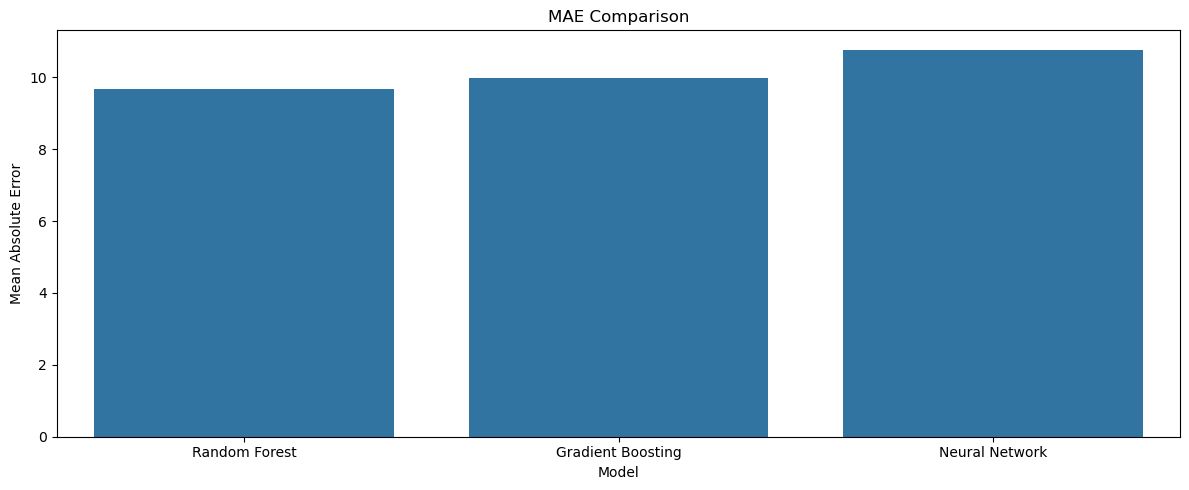

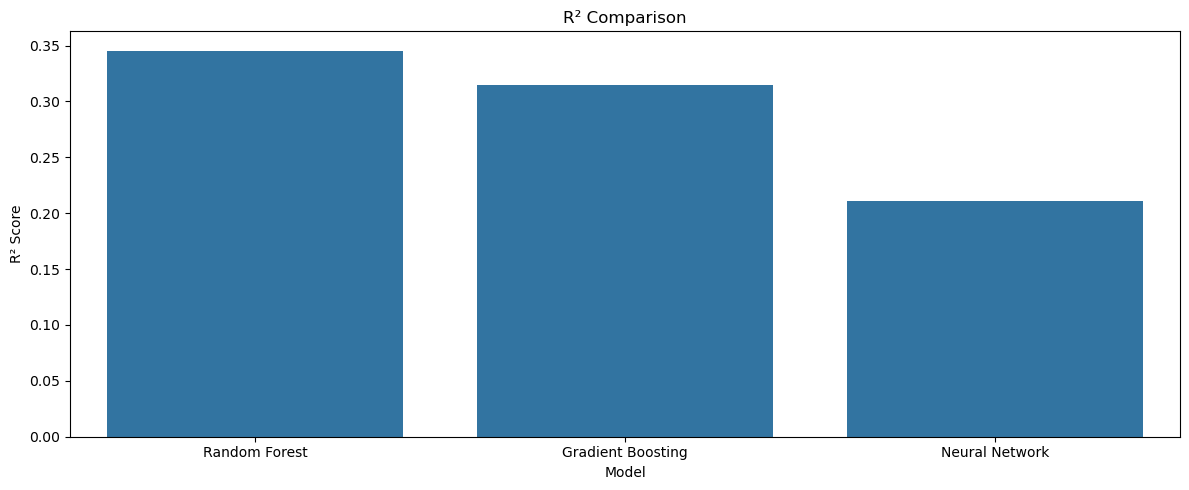

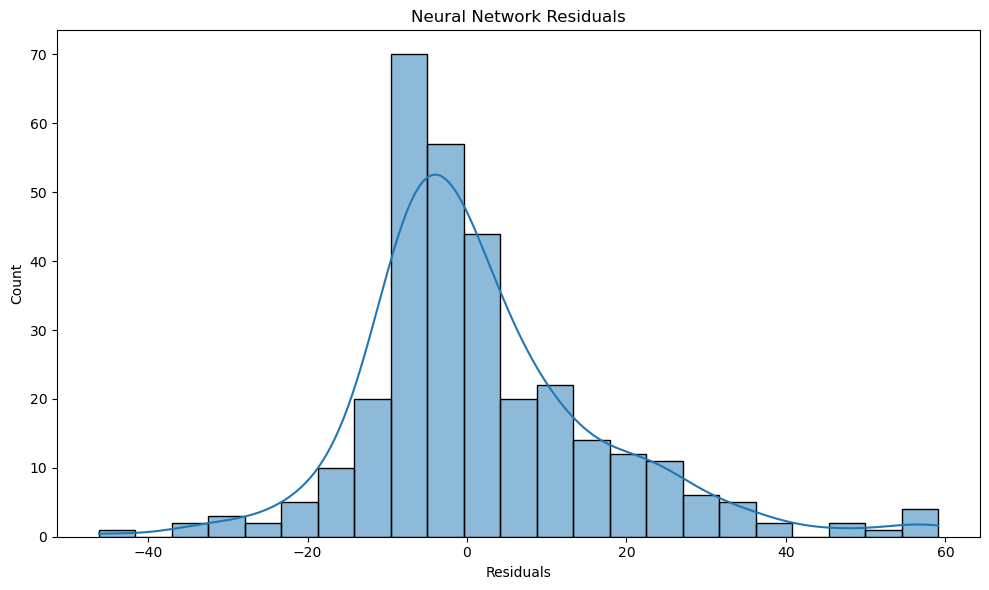

In [11]:
# Compare model performance
models = ['Random Forest', 'Gradient Boosting', 'Neural Network']
maes = [rf_mae, gb_mae, nn_mae]
r2s = [rf_r2, gb_r2, nn_r2]

# MAE Comparison Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=models, y=maes)
plt.title("MAE Comparison")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error")
plt.tight_layout()
plt.savefig("mae_comparison.png")
plt.show()

# R² Comparison Plot
plt.figure(figsize=(12, 5))
sns.barplot(x=models, y=r2s)
plt.title("R² Comparison")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.tight_layout()
plt.savefig("r2_comparison.png")
plt.show()

# Residual Analysis for the Neural Network
residuals = y_test - nn_preds
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Neural Network Residuals")
plt.xlabel("Residuals")
plt.tight_layout()
plt.savefig("nn_residuals.png")
plt.show()

# Save the evaluation metrics to a CSV file
results_df = pd.DataFrame({
    'Model': models,
    'MAE': maes,
    'R2': r2s
})
results_df.to_csv("model_results.csv", index=False)